In [1]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.ensemble import RandomForestClassifier
import xgboost

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../Final Project/Data/playstore_data.csv",header=0,encoding='utf-8')
df = dataset.copy()

In [3]:
df.head()

,ID,Application,Users,Stars,Approval,Review
0,1,Spotify,RealTRG,5,2,Ich finde Spotify sehr gut. Die Lieder haben e...
1,2,Spotify,Lokan,1,7,Fix the adaptive icon please ðŸ˜­
2,3,Spotify,Abhilash Ulahannan,2,1,"missing a lot of songs i like, not really a fa..."
3,4,Spotify,Michele LaBlanc,4,12,Overall great app. Love that I can have multip...
4,5,Spotify,Makara Bedell,5,7,"it's good and all, but ur recent update is tra..."


# Implementing Vader

In [4]:
# Initializing the Vader Sentiment Analyzer Method

analyser = SentimentIntensityAnalyzer()

In [5]:
# Calculating Sentiment Scores for our Tweets and Appending them to a list

scores = []
for items in df['Review']:
    score = analyser.polarity_scores(items)
    scores.append(score)

In [6]:
# Based on the Scores List which is a list of dictionaries, evaluating the final sentiment based on compound score

final = []
for items in scores:
    if items['compound'] >= 0.05:
        final.append("Positive")
    elif items['compound'] <= -0.05:
        final.append("Negative")
    else:
        final.append("Neutral")

In [7]:
# Appending the Final Sentiment to our Initial Dataset

final = pd.DataFrame(final,columns = ['Vader Sentiment'])
df['Vader Sentiment'] = final

In [8]:
df.head()

,ID,Application,Users,Stars,Approval,Review,Vader Sentiment
0,1,Spotify,RealTRG,5,2,Ich finde Spotify sehr gut. Die Lieder haben e...,Negative
1,2,Spotify,Lokan,1,7,Fix the adaptive icon please ðŸ˜­,Positive
2,3,Spotify,Abhilash Ulahannan,2,1,"missing a lot of songs i like, not really a fa...",Positive
3,4,Spotify,Michele LaBlanc,4,12,Overall great app. Love that I can have multip...,Positive
4,5,Spotify,Makara Bedell,5,7,"it's good and all, but ur recent update is tra...",Positive


In [9]:
# Final Sentiment Tagged Dataset

df.head()

df.to_csv("../Final Project/Data/Vader Sentiment PlayStore.csv")

# Sentiment Data as Training & Preprocessing

In [10]:
# Splitting Independent and Dependent Variables
text_data = df['Review']
label_data = df['Vader Sentiment']

In [11]:
# Converting list to Dataframes
text_data = pd.DataFrame(text_data,columns=['Review'])
label_data = pd.DataFrame(label_data,columns=['Vader Sentiment'])

In [12]:
# Splitting the Data into Training and Test Sets
Train_text, Test_text, Train_labels, Test_labels = train_test_split(text_data, label_data, test_size=0.2,shuffle=False)

In [13]:
# Data Preprocessing: a.Dropping Nulls

Train_text['Review'].dropna(inplace=True)
Test_text['Review'].dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:3896: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [14]:
# Data Preprocessing: b.Converting Data to Lowercase

Train_text['Review'] = [entry.lower() for entry in Train_text['Review']]
Test_text['Review'] = [entry.lower() for entry in Test_text['Review']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
# Data Preprocessing: c.Tokenizing Data

Train_text['Review']= [word_tokenize(entry) for entry in Train_text['Review']]
Test_text['Review']= [word_tokenize(entry) for entry in Test_text['Review']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [16]:
# Data Preprocessing: d.Tagging Words to their Types

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [17]:
# Data Preprocessing: e.Lemmatizing Training Data and Removing Stopwords

big_list = []
for index,entry in enumerate(Train_text['Review']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    big_list.append(Final_words)

In [18]:
# Bringing Training Data to Correct Format

train_text = pd.Series(str(items) for items in big_list)
train_text.head()

0    ['ich', 'finde', 'spotify', 'sehr', 'gut', 'di...
1                ['fix', 'adaptive', 'icon', 'please']
2    ['miss', 'lot', 'song', 'like', 'really', 'fan...
3    ['overall', 'great', 'app', 'love', 'multiple'...
4    ['good', 'ur', 'recent', 'update', 'trash', 'b...
dtype: object

In [19]:
big_list

[['ich',
  'finde',
  'spotify',
  'sehr',
  'gut',
  'die',
  'lied',
  'haben',
  'eine',
  'hohe',
  'und',
  'das',
  'design',
  'sieht',
  'sehr',
  'gut',
  'au',
  'der',
  'support',
  'war',
  'auch',
  'sehr',
  'hilfsbereit',
  'und',
  'hat',
  'mir',
  'bei',
  'meinen',
  'problemen',
  'geholfen',
  'und',
  'sie',
  'auf'],
 ['fix', 'adaptive', 'icon', 'please'],
 ['miss',
  'lot',
  'song',
  'like',
  'really',
  'fan',
  'indian',
  'content',
  'like',
  'alterbrigde',
  'slipknot',
  'lead',
  'zeppelin',
  'miss',
  'dont',
  'understand',
  'even',
  'buy',
  'premium',
  'version',
  'enjoy',
  'u',
  'content',
  'free',
  'version',
  'use',
  'vpn',
  'like',
  'everything',
  'spotify',
  'except',
  'understand',
  'right',
  'issue',
  'isnt',
  'go',
  'good',
  'enough'],
 ['overall',
  'great',
  'app',
  'love',
  'multiple',
  'playlist',
  'song',
  'search',
  'unavailable',
  'complaint',
  'last',
  'update',
  'longer',
  'scroll',
  'song',
  '

In [20]:
# Data Preprocessing: e.Lemmatizing Test Data and Removing Stopwords

big_list_1 = []
for index,entry in enumerate(Test_text['Review']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    big_list_1.append(Final_words)

In [21]:
# Bringing Test Data to Correct Format

test_text = pd.Series(str(items) for items in big_list_1)
test_text.head()

0                ['great', 'music', 'listen', 'world']
1    ['work', 'fine', 'shortly', 'late', 'update', ...
2    ['listen', 'pandora', 'year', 'best', 'music',...
3    ['great', 'somthing', 'u', 'want', 'listen', '...
4    ['stop', 'every', 'time', 'minimize', 'go', 'a...
dtype: object

In [22]:
# Generating A Total Corpus of Words

all_texts = []
for items in train_text:
    all_texts.append(items)

for items in test_text:
    all_texts.append(items)

In [23]:
train_text

0        ['ich', 'finde', 'spotify', 'sehr', 'gut', 'di...
1                    ['fix', 'adaptive', 'icon', 'please']
2        ['miss', 'lot', 'song', 'like', 'really', 'fan...
3        ['overall', 'great', 'app', 'love', 'multiple'...
4        ['good', 'ur', 'recent', 'update', 'trash', 'b...
5        ['love', 'app', 'thing', 'help', 'get', 'day',...
6        ['spotify', 'great', 'streaming', 'service', '...
7        ['really', 'love', 'app', 'super', 'convenient...
8          ['lot', 'artist', 'add', 'miss', 'lot', 'song']
9        ['cant', 'save', 'music', 'automatically', 'gr...
10       ['unstable', 'far', 'many', 'bug', 'amount', '...
11       ['awesome', 'app', 'need', 'debit', 'card', 'p...
12               ['great', 'every', 'obnoxious', 'update']
13       ['lot', 'music', 'miss', 'indian', 'library', ...
14                 ['great', 'app', 'highly', 'recommend']
15                      ['best', 'music', 'stream', 'app']
16                                 ['hate', 'new', 'icon

In [24]:
# Label Encoding

Encoder = LabelEncoder()
train_labels = Encoder.fit_transform(Train_labels)
test_labels = Encoder.fit_transform(Test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Selecting Features

### Count Vectors as Features

In [25]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(all_texts)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_text)
xvalid_count =  count_vect.transform(test_text)

In [26]:
all_texts

["['ich', 'finde', 'spotify', 'sehr', 'gut', 'die', 'lied', 'haben', 'eine', 'hohe', 'und', 'das', 'design', 'sieht', 'sehr', 'gut', 'au', 'der', 'support', 'war', 'auch', 'sehr', 'hilfsbereit', 'und', 'hat', 'mir', 'bei', 'meinen', 'problemen', 'geholfen', 'und', 'sie', 'auf']",
 "['fix', 'adaptive', 'icon', 'please']",
 "['miss', 'lot', 'song', 'like', 'really', 'fan', 'indian', 'content', 'like', 'alterbrigde', 'slipknot', 'lead', 'zeppelin', 'miss', 'dont', 'understand', 'even', 'buy', 'premium', 'version', 'enjoy', 'u', 'content', 'free', 'version', 'use', 'vpn', 'like', 'everything', 'spotify', 'except', 'understand', 'right', 'issue', 'isnt', 'go', 'good', 'enough']",
 "['overall', 'great', 'app', 'love', 'multiple', 'playlist', 'song', 'search', 'unavailable', 'complaint', 'last', 'update', 'longer', 'scroll', 'song', 'screen', 'share', 'song', 'fb', 'text', 'every', 'time', 'try', 'scroll', 'spotify', 'crash', 'miss', 'feature', 'please', 'fix']",
 "['good', 'ur', 'recent', 'u

### Word Level TF-IDF as Features

In [27]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word',max_features=5000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train_text)
xvalid_tfidf =  tfidf_vect.transform(test_text)

In [28]:
type(train_text)

pandas.core.series.Series

### N-Gram Level TF-IDF as Features

In [29]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=5000)
tfidf_vect_ngram.fit(all_texts)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_text)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(test_text)

# Creating a Function to Deploy Models

In [30]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, test_labels)

# Deploying Models

# Naive Bayes

In [31]:
# Naive Bayes on Count Vectors
accuracy_count_nb = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_labels, xvalid_count)
print ("NB, Count Vectors: ", accuracy_count_nb)

# Naive Bayes on Word Level TF IDF Vectors
accuracy_word_nb = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_labels, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy_word_nb)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_ngram_nb = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_labels, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy_ngram_nb)

NB, Count Vectors:  0.7284953768562623
NB, WordLevel TF-IDF:  0.7175679462034183
NB, N-Gram Vectors:  0.7270944242084617


# RF Classifier

In [32]:
#Random Forest on Count Vectors
accuracy_count_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_count,train_labels,xvalid_count)
print("RF, Count Vectors: ",accuracy_count_rf)

#Random Forest on Word Level TF IDF Vectors
accuracy_word_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_tfidf,train_labels,xvalid_tfidf)
print("RF, WordLevel TF-IDF Vectors: ",accuracy_word_rf)

#Random Forest Ngram Level TF IDF Vectors
accuracy_ngram_rf = train_model(RandomForestClassifier(n_estimators=100),xtrain_tfidf_ngram,train_labels,xvalid_tfidf_ngram)
print("RF, N-Gram Vectors: ",accuracy_ngram_rf)

RF, Count Vectors:  0.7965816755393668
RF, WordLevel TF-IDF Vectors:  0.8089100588400112
RF, N-Gram Vectors:  0.7991033903054077


# Logistic Regression

In [33]:
# Linear Classifier on Count Vectors
accuracy_count_lc = train_model(linear_model.LogisticRegression(), xtrain_count, train_labels, xvalid_count)
print ("LR, Count Vectors: ", accuracy_count_lc)

# Linear Classifier on Word Level TF IDF Vectors
accuracy_word_lc = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_labels, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy_word_lc)

# Linear Classifier on Ngram Level TF IDF Vectorstrain_labels
accuracy_ngram_lc = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_labels, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy_ngram_lc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR, Count Vectors:  0.8327262538526198
LR, WordLevel TF-IDF:  0.8147940599607734
LR, N-Gram Vectors:  0.8097506304286916


# SVM

In [34]:
# SVM on Count Vectors Linear Kernel
accuracy_count_svm = train_model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), xtrain_count, train_labels, xvalid_count)
print ("SVM,Count Vectors: ", accuracy_count_svm)

# SVM on Word Level TF-IDF Vectors Linear Kernel
accuracy_word_svm = train_model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), xtrain_tfidf, train_labels, xvalid_tfidf)
print ("SVM, Word Level TF-IDF Vectors: ", accuracy_word_svm)

# SVM on Ngram Level TF IDF Vectors  Linear Kernel
accuracy_ngram_svm = train_model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), xtrain_tfidf_ngram, train_labels, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy_ngram_svm)


SVM,Count Vectors:  0.8257214906136172
SVM, Word Level TF-IDF Vectors:  0.8318856822639394
SVM, N-Gram Vectors:  0.8220790137293359


# Bagging

In [35]:
# RF on Count Vectors
accuracy_count_bg = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_labels, xvalid_count)
print ("RF, Count Vectors: ", accuracy_count_bg)

# RF on Word Level TF IDF Vectors
accuracy_word_bg = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_labels, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy_word_bg)

# RF on Ngram Vectors
accuracy_ngram_bg = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_labels, xvalid_tfidf_ngram)
print ("RF, Ngram Vectors: ", accuracy_ngram_bg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors:  0.7688428131129168


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, WordLevel TF-IDF:  0.7685626225833567


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Ngram Vectors:  0.7719249089380779


# Boosting

In [36]:
# Extereme Gradient Boosting on Count Vectors
accuracy_count_bo = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_labels, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy_count_bo)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy_word_bo = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_labels, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy_word_bo)

# Extereme Gradient Boosting on NGRAM Level TF IDF Vectors
accuracy_ngram_bo = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_labels, xvalid_tfidf_ngram.tocsc())
print ("Xgb, Ngram Level Vectors: ", accuracy_ngram_bo)

Xgb, Count Vectors:  0.7752871952927991
Xgb, WordLevel TF-IDF:  0.7867750070047632
Xgb, Ngram Level Vectors:  0.7878957691230036


# Summary

## Using Count Vectors

In [37]:
# print('Naive Bayes Classifier')
print ("NB, Count Vectors: ", round(accuracy_count_nb*100,2),"%")
print("")

print('Random Forest Classifier')
print("RF, Count Vectors: ",round(accuracy_count_rf*100,2),"%")
print("")

print('Linear Classifier')
print ("LR, Count Vectors: ", round(accuracy_count_lc*100,2),"%")
print("")

print('SVM Classifier')
print ("SVM,Count Vectors: ", round(accuracy_count_svm*100,2),"%")
print("")

print('Bagging Classifier')
print ("RF, Count Vectors: ", round(accuracy_count_bg*100,2),"%")
print("")

print('Boosting Classifier')
print ("Xgb, Count Vectors: ", round(accuracy_count_bo*100,2),"%")
print("")

NB, Count Vectors:  72.85 %

Random Forest Classifier
RF, Count Vectors:  79.66 %

Linear Classifier
LR, Count Vectors:  83.27 %

SVM Classifier
SVM,Count Vectors:  82.57 %

Bagging Classifier
RF, Count Vectors:  76.88 %

Boosting Classifier
Xgb, Count Vectors:  77.53 %



## Using Word Level TF-IDF

In [38]:
print('Naive Bayes Classifier')
print ("NB, WordLevel TF-IDF: ", round(accuracy_word_nb*100,2),"%")
print("")

print('Random Forest Classifier')
print("RF, WordLevel TF-IDF Vectors: ",round(accuracy_word_rf*100,2),"%")
print("")

print('Linear Classifier')
print ("LR, WordLevel TF-IDF: ", round(accuracy_word_lc*100,2),"%")
print("")

print('SVM Classifier')
print ("SVM, Word Level TF-IDF Vectors: ", round(accuracy_word_svm*100,2),"%")
print("")

print('Bagging Classifier')
print ("RF, WordLevel TF-IDF: ", round(accuracy_word_bg*100,2),"%")
print("")

print('Boosting Classifier')
print ("Xgb, WordLevel TF-IDF: ", round(accuracy_word_bo*100,2),"%")
print("")

Naive Bayes Classifier
NB, WordLevel TF-IDF:  71.76 %

Random Forest Classifier
RF, WordLevel TF-IDF Vectors:  80.89 %

Linear Classifier
LR, WordLevel TF-IDF:  81.48 %

SVM Classifier
SVM, Word Level TF-IDF Vectors:  83.19 %

Bagging Classifier
RF, WordLevel TF-IDF:  76.86 %

Boosting Classifier
Xgb, WordLevel TF-IDF:  78.68 %



## Using N-Gram Vectors

In [39]:
print('Naive Bayes Classifier')
print ("NB, Ngram Vectors: ", round(accuracy_ngram_nb*100,2),"%")
print("")

print('Random Forest Classifier')
print("RF, Ngram Vectors: ",round(accuracy_ngram_rf*100,2),"%")
print("")

print('Linear Classifier')
print ("LR, Ngram Vectors: ", round(accuracy_ngram_lc*100,2),"%")
print("")

print('SVM Classifier')
print ("SVM, Ngram Vectors: ", round(accuracy_ngram_svm*100,2),"%")
print("")

print('Bagging Classifier')
print ("RF, Ngram Vectors: ", round(accuracy_ngram_bg*100,2),"%")
print("")

print('Boosting Classifier')
print ("Xgb, Ngram Vectors: ", round(accuracy_ngram_bo*100,2),"%")
print("")

Naive Bayes Classifier
NB, Ngram Vectors:  72.71 %

Random Forest Classifier
RF, Ngram Vectors:  79.91 %

Linear Classifier
LR, Ngram Vectors:  80.98 %

SVM Classifier
SVM, Ngram Vectors:  82.21 %

Bagging Classifier
RF, Ngram Vectors:  77.19 %

Boosting Classifier
Xgb, Ngram Vectors:  78.79 %



# Hyperparameter Tuning the SVM

In [40]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [40]:
# SVM on Word Level TF-IDF Vectors Linear Kernel
accuracy_word_svm = train_model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma=0.001), xtrain_tfidf, train_labels, xvalid_tfidf)
print ("SVM, Word Level TF-IDF Vectors: ", round(accuracy_word_svm*100,2),"%")

SVM, Word Level TF-IDF Vectors:  83.19 %


# Confusion Matrix

In [86]:
# Plotting the confusion Matrix Using Logistic Regression on Word Level TF-IDF

import matplotlib as mpl
import numpy as np


def plot_cm(X, y, clf, title):

    cm = metrics.confusion_matrix(y, clf.predict(X))

    np.set_printoptions(suppress=True)
    mpl.rc("figure", figsize=(8, 4))

    hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['negative','neutral','positive'],
            xticklabels=['negative','neutral','positive'],
            cmap='Blues'
            )
    plt.title(title)
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    plt.show()

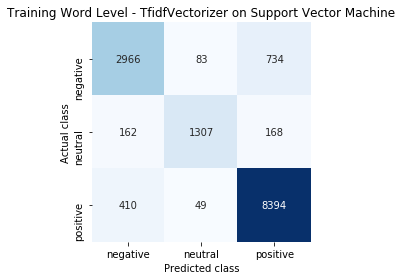

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

claf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma=0.001)
claf.fit(xtrain_tfidf, train_labels)
plot_cm(xtrain_tfidf, train_labels, claf, 'Training Word Level - TfidfVectorizer on Support Vector Machine')

In [88]:
train_labels

array([0, 2, 2, ..., 1, 2, 1])

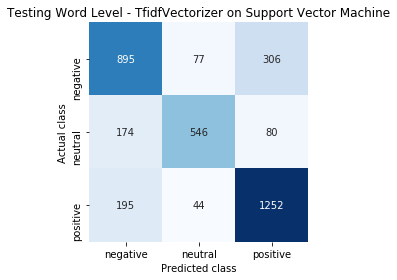

In [89]:
plot_cm(xvalid_tfidf,test_labels, claf, 'Testing Word Level - TfidfVectorizer on Support Vector Machine')

# Deploying Model

In [ ]:
import mlflow.sklearn
import mlflow
model_path="/Users/rohitjain/Desktop/PythonProjects/playstore/model"
mlflow.sklearn.save_model(claf, model_path,serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

# Pickling Vectorizer

In [103]:
import pickle
with open('/Users/rohitjain/Desktop/PythonProjects/playstore/tfidfvectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vect,file)